# Use pretrained resnet50 model to classify flower image

## first import all the needed libraries

In [1]:
import numpy as np
import random 
import cv2

import PIL.Image as Image
import os
import pathlib

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split

## second download dataset and get it's path

In [2]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz" # link of dataset
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url,  cache_dir='.', untar=True)
# cache_dir indicates where to download data. I specified "." which means current directory
# untar true will unzip it

In [3]:
data_dir = pathlib.Path(data_dir)  # convert format of path from string to windowPath
data_dir # path of the dataset

WindowsPath('datasets/flower_photos')

## Read flowers images from disk into numpy array using opencv

####  1) create a dictionary in which keys are the type/label of flowers and value is a list of img's paths of flowers of this type 

In [4]:
flowers_images_dict = {
    'roses': list(data_dir.glob('roses/*')),
    'daisy': list(data_dir.glob('daisy/*')),
    'dandelion': list(data_dir.glob('dandelion/*')),
    'sunflowers': list(data_dir.glob('sunflowers/*')),
    'tulips': list(data_dir.glob('tulips/*')),
}

In [5]:
for flower_name, images in flowers_images_dict.items():
    print('number of imgs of {} class is {}'.format(flower_name , len(images)))

number of imgs of roses class is 641
number of imgs of daisy class is 633
number of imgs of dandelion class is 898
number of imgs of sunflowers class is 699
number of imgs of tulips class is 799


#### 2) create a dictionary in which we map each label to an index

In [6]:
flowers_labels_dict = {
    'roses': 0,
    'daisy': 1,
    'dandelion': 2,
    'sunflowers': 3,
    'tulips': 4,
}

## Now lets's create two numpy arrays which we will call X and Y for now
#### X will hold data (images)
#### Y will hold label of corrsponding img

In [7]:
X, y = [], []

for flower_name, images in flowers_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(224,224))
        X.append(resized_img)
        y.append(flowers_labels_dict[flower_name])

In [8]:
X = np.array(X) 
y = np.array(y)

## split data into train and test 

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=0)
# 80% of our data will be used for training and other 20% will be used for testing

In [10]:
print("size of training data is {} and the dim".format(len(X_train)))
print("size of test data is {}".format(len(X_test)))
print("dimensions of each example is {}".format(X_train[0].shape))

size of training data is 2936 and the dim
size of test data is 734
dimensions of each example is (224, 224, 3)


In [11]:
# scale the image value to be in range of [0-1]
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

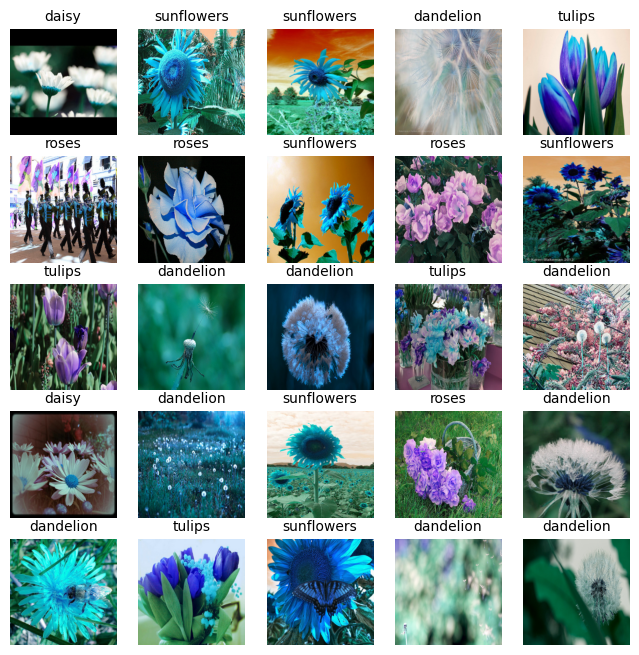

In [12]:
def plot_data (rows , cols):
    labels = list(flowers_labels_dict.keys())
    fig, axes = plt.subplots(rows , cols , figsize=(8,8))
    fig.subplots_adjust(wspace=0.2)
    fig.subplots_adjust(hspace=0.2)
    index = random.randint(0,len(X_train)-rows*cols)
    for row in range(rows):
        for col in range(cols):
            img  = X_train[index]
            label = y_train[index]
            axes[row,col].imshow(img)
            axes[row,col].set_title('{}'.format(labels[label]) , fontsize = 10)
            axes[row,col].axis('off')
            index = index + 1  
            
plot_data(5,5)         

## use pretrained model resnet50 to classify our flower images

In [13]:
num_classes = 5
m = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/tensorflow/resnet_50/feature_vector/1",trainable=False),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
m.build([None, 224, 224, 3])  # Batch input shape.


In [14]:
m.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              23561152  
                                                                 
 dense (Dense)               (None, 5)                 10245     
                                                                 
Total params: 23,571,397
Trainable params: 10,245
Non-trainable params: 23,561,152
_________________________________________________________________


In [15]:
def plot_history(history, metric = None):
  # Plots the loss history of training and validation (if existing)
  # and a given metric
  
  if metric != None:
    fig, axes = plt.subplots(2,1)
    axes[0].plot(history.history[metric])
    axes[0].set_title('{:s}'.format(metric))
    axes[0].set_ylabel('{:s}'.format(metric))
    axes[0].set_xlabel('Epoch')
    
    fig.subplots_adjust(hspace=0.5)
    
    axes[1].plot(history.history['loss'])
    axes[1].set_title('Model Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    
  else:
    plt.plot(history.history['loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')

In [16]:
m.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['acc'])
history = m.fit(X_train_scaled, y_train, epochs=5)

Epoch 1/5
92/92 [==============================] - 299s 3s/step - loss: 0.5885 - acc: 0.7790
Epoch 2/5
92/92 [==============================] - 271s 3s/step - loss: 0.2734 - acc: 0.9043
Epoch 3/5
92/92 [==============================] - 272s 3s/step - loss: 0.1931 - acc: 0.9384
Epoch 4/5
92/92 [==============================] - 271s 3s/step - loss: 0.1563 - acc: 0.9537
Epoch 5/5
92/92 [==============================] - 271s 3s/step - loss: 0.1235 - acc: 0.9663


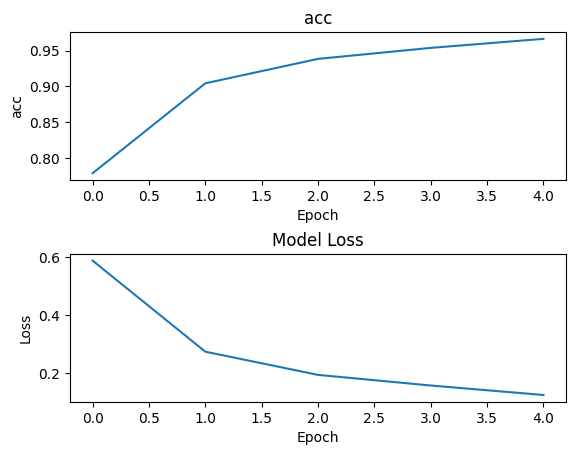

In [17]:
plot_history(history , "acc")

In [18]:
m.evaluate(X_test_scaled,y_test)

23/23 [==============================] - 70s 3s/step - loss: 0.2853 - acc: 0.9060


[0.285290390253067, 0.9059945344924927]